## Imports

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
import seaborn as sns
from pykalman import KalmanFilter
from math import sqrt
import warnings
import ffn
import pyfolio as pf

In [7]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## 1. Data Acquisition

In [8]:
# Define start and end for strategy
start_date = "2019-01-01"
end_date = "2025-01-01"

# Define the companies and acquire the data
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "AMD", "TM", "JPM", "SPY",
    "META", "NFLX", "UNH", "NKE", "MA", "HD", "JNJ", "PFE", "LLY", "MRK",
]
data = yf.download(tickers=tickers, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  20 of 20 completed


In [9]:
# Visualise
data.head()

Price       Adj Close                                               \
Ticker           AAPL        AMD       AMZN      GOOGL          HD   
Date                                                                 
2019-01-02  37.617847  18.830000  76.956497  52.419624  146.935699   
2019-01-03  33.870838  17.049999  75.014000  50.967831  143.697113   
2019-01-04  35.316750  19.000000  78.769501  53.582146  147.966888   
2019-01-07  35.238159  20.570000  81.475502  53.475292  150.881592   
2019-01-08  35.909904  20.750000  82.829002  53.944973  151.605972   

Price                                                                  \
Ticker             JNJ        JPM         LLY          MA        META   
Date                                                                    
2019-01-02  106.384323  82.408623  104.899414  182.926590  135.043518   
2019-01-03  104.693817  81.237442  101.639549  174.674011  131.122009   
2019-01-04  106.450935  84.232300  104.698517  182.945908  137.302872   
2019-01-07  105.768066  84.290871  105.264656  184.353500  137.402420   
2019-01-08  108.224693  84.131912  106.232536  185.695877  141.861420   

Price                                                                         \
Ticker            MRK       MSFT        NFLX        NKE      NVDA        PFE   
Date                                                                           
2019-01-02  59.732021  94.945511  267.660004  68.385033  3.377545  30.832535   
2019-01-03  58.507195  91.452644  271.200012  67.175430  3.173484  29.969942   
2019-01-04  60.269371  95.706032  297.570007  68.929840  3.376801  30.654322   
2019-01-07  59.605568  95.828133  315.339996  69.917831  3.555571  30.818277   
2019-01-08  60.048092  96.522919  320.269989  70.850456  3.467054  30.960852   

Price                                                          Close  \
Ticker             SPY          TM       TSLA         UNH       AAPL   
Date                                                                   
2019-01-02  226.954727   99.789780  20.674667  221.528595  39.480000   
2019-01-03  221.539017   98.390961  20.024000  215.487488  35.547501   
2019-01-04  228.959595  102.750526  21.179333  218.007584  37.064999   
2019-01-07  230.764877  104.080727  22.330667  218.426132  36.982498   
2019-01-08  232.932968  104.964653  22.356667  221.346588  37.687500   

Price                                                                \
Ticker            AMD       AMZN      GOOGL          HD         JNJ   
Date                                                                  
2019-01-02  18.830000  76.956497  52.734001  172.410004  127.750000   
2019-01-03  17.049999  75.014000  51.273499  168.610001  125.720001   
2019-01-04  19.000000  78.769501  53.903500  173.619995  127.830002   
2019-01-07  20.570000  81.475502  53.796001  177.039993  127.010002   
2019-01-08  20.750000  82.829002  54.268501  177.889999  129.960007   

Price                                                                  \
Ticker             JPM         LLY          MA        META        MRK   
Date                                                                    
2019-01-02   99.309998  114.879997  189.740005  135.679993  72.127861   
2019-01-03   97.110001  111.309998  181.179993  131.740005  70.648857   
2019-01-04  100.690002  114.660004  189.759995  137.949997  72.776718   
2019-01-07  100.760002  115.279999  191.220001  138.050003  71.975189   
2019-01-08  100.570000  116.339996  192.279999  142.529999  72.509544   

Price                                                                          \
Ticker            MSFT        NFLX        NKE     NVDA        PFE         SPY   
Date                                                                            
2019-01-02  101.120003  267.660004  74.059998  3.40550  41.034157  250.179993   
2019-01-03   97.400002  271.200012  72.750000  3.19975  39.886147  244.210007   
2019-01-04  101.930000  297.570007  74.650002  3.40475  40.796963  252.389999

In [10]:
def get_prices(tickers, data, ohlc="Adj Close", start_date=None, end_date=None):
    """
    Gets prices of given ticker symbol from Yahoo Finace
    """
    prices = []
    for ticker in tickers:
        # Get prices for each ticker
        ticker_data = data[(ohlc, ticker)]

        # Column name is just name of stock 
        ticker_data = ticker_data.rename(ticker)

        # Add this to the prices
        prices.append(ticker_data)

    df_prices = pd.concat(prices, axis=1)

    return df_prices

# Get the prices for all the stocks
ohlc = "Adj Close"
df_prices = get_prices(tickers, data, ohlc=ohlc, start_date=start_date, end_date=end_date)

# Sanity check
df_prices.info()
df_prices.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2019-01-02 to 2024-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1510 non-null   float64
 1   MSFT    1510 non-null   float64
 2   GOOGL   1510 non-null   float64
 3   AMZN    1510 non-null   float64
 4   TSLA    1510 non-null   float64
 5   NVDA    1510 non-null   float64
 6   AMD     1510 non-null   float64
 7   TM      1510 non-null   float64
 8   JPM     1510 non-null   float64
 9   SPY     1510 non-null   float64
 10  META    1510 non-null   float64
 11  NFLX    1510 non-null   float64
 12  UNH     1510 non-null   float64
 13  NKE     1510 non-null   float64
 14  MA      1510 non-null   float64
 15  HD      1510 non-null   float64
 16  JNJ     1510 non-null   float64
 17  PFE     1510 non-null   float64
 18  LLY     1510 non-null   float64
 19  MRK     1510 non-null   float64
dtypes: float64(20)
memory usage: 247.7 KB


,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA,AMD,TM,JPM,SPY,META,NFLX,UNH,NKE,MA,HD,JNJ,PFE,LLY,MRK
Date,,,,,,,,,,,,,,,,,,,,
2024-12-24,257.578674,437.647369,195.647552,229.050003,462.279999,140.197372,126.290001,181.429993,239.589218,599.496582,607.209778,932.119995,503.946320,75.898903,534.074524,391.210724,143.461914,25.812685,792.676208,98.598198
2024-12-26,258.396667,436.432068,195.138748,227.050003,454.130005,139.907410,125.059998,197.360001,240.409912,599.536499,602.813660,924.140015,508.974823,76.047165,534.513184,390.223206,143.196320,25.638927,791.152039,99.014610
2024-12-27,254.974930,428.881104,192.305435,223.750000,431.660004,136.987885,125.190002,199.520004,238.462036,593.225464,599.276855,907.549988,507.819733,75.533188,530.575195,387.971527,142.675003,25.696848,780.223267,98.846062
2024-12-30,251.593094,423.202911,190.789047,221.300003,417.410004,137.467804,122.440002,195.660004,236.632812,586.455811,590.714417,900.429993,505.639069,73.783730,523.945557,384.584198,140.992996,25.503784,770.928406,97.527458
2024-12-31,249.817383,419.885681,188.853607,219.389999,403.839996,134.268326,120.790001,194.610001,237.018433,584.322266,584.989563,891.320007,503.707306,74.791893,524.962402,384.149658,142.252045,25.609970,769.095337,98.627953


## 2. Data Visualisation

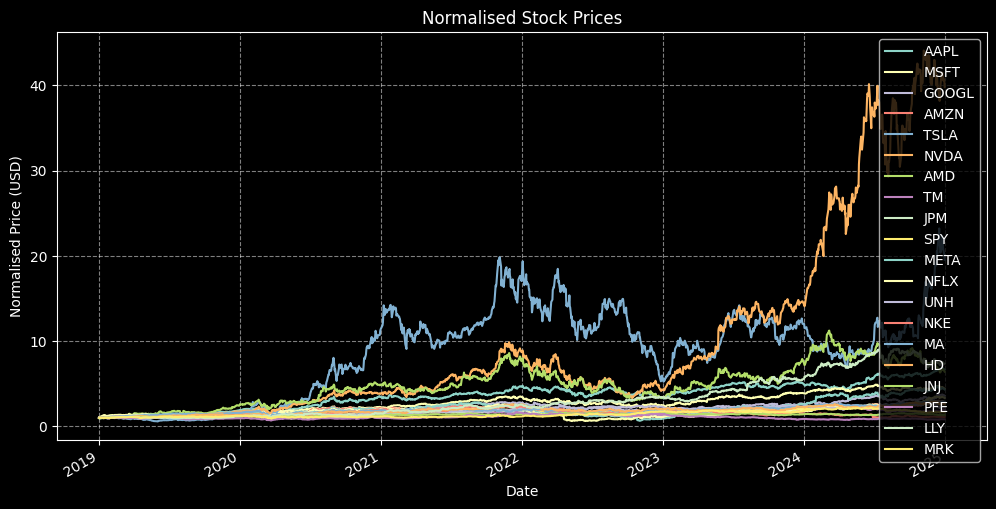

In [11]:
# Normalise the stock prices
df_prices_norm = df_prices.div(df_prices.iloc[0, :])

# Plotting
plt.style.use("dark_background")
df_prices_norm.plot(figsize=(12, 6), title="Normalised Stock Prices", xlabel="Date", ylabel="Normalised Price (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 3. Cointegration
- Consider a non-stationary time series $X_t \sim I(1)$, representing the price of our security.
- For cointegration to exist:

$$
    X_{1, t} - \beta_t X_{2, t} = u_t
$$

- Where $u_t$ is a stationary process, $I(0)$, representing the spread.

In [12]:
def find_cointegrated_pairs(df, critical_value=0.05):
    # Number of stocks
    n = df.shape[1]

    # Matrix of p-values (n x n)
    P = np.ones((n, n))

    # Names of the stocks
    stocks = df.columns
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            # Stock prices
            X_1 = df[stocks[i]]
            X_2 = df[stocks[j]]

            # Cointegration test results (t_statistic, p_value, critical_values)
            result = sm.tsa.coint(X_1, X_2)
            p_value = result[1]
            P[i, j] = p_value

            # Store valid cointegration pairs
            if p_value < critical_value:
                pairs.append((stocks[i], stocks[j], p_value))

    return (P, pairs)

In [13]:
# Partition dataset into "training" where the remainder will be used for backtesting
split_size = 0.3
split = int(len(df_prices_norm) * split_size)

# Stock price names
stocks = df_prices_norm.columns

# Get cointegrated pairs
P_mat, pairs = find_cointegrated_pairs(df_prices_norm[:split])
df_pvalue_matrix = pd.DataFrame(P_mat)

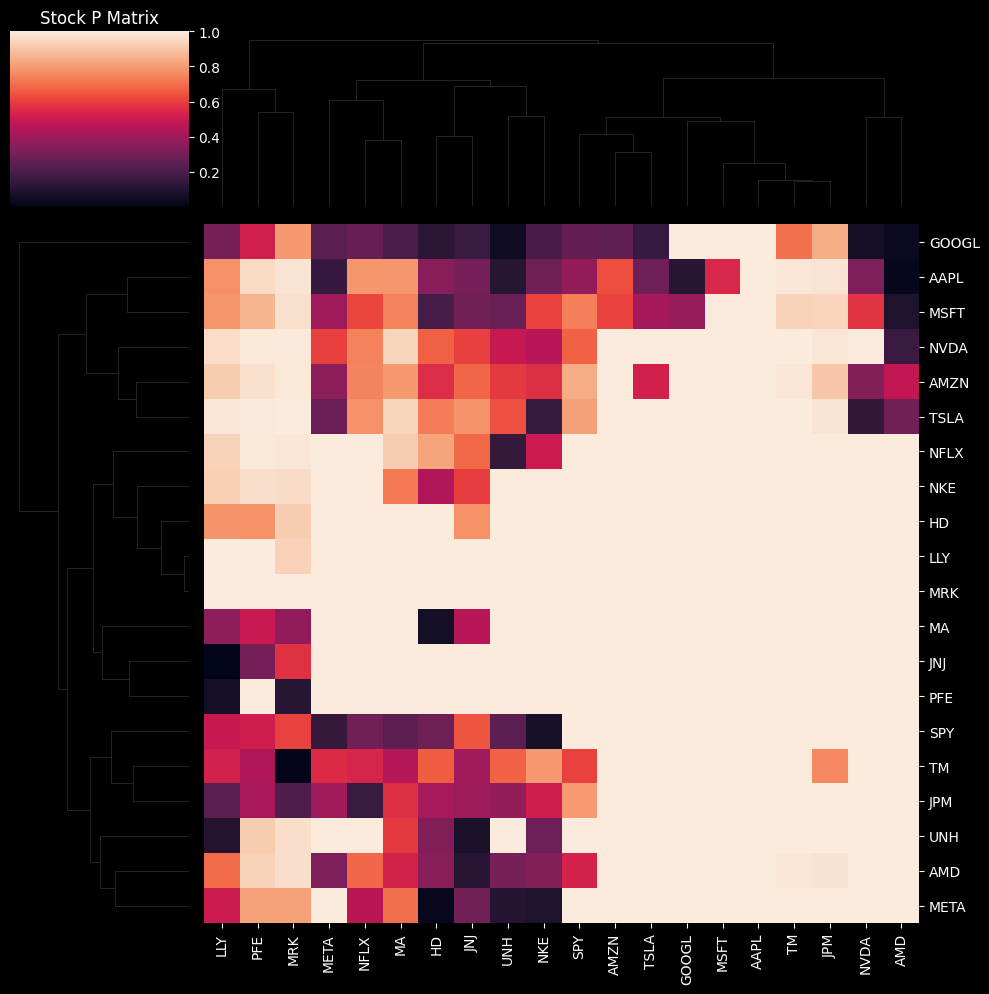

In [14]:
# Heatmap
sns.clustermap(df_pvalue_matrix, xticklabels=stocks, yticklabels=stocks)
plt.title("Stock P Matrix")
plt.tight_layout()
plt.show()

- As the heatmap displayed some dark values where $p < 5\%$, we can find these cointegrated pairs.

In [15]:
for pair in pairs:
    print(f"Asset {pair[0]} and Asset {pair[1]} have a cointegration score of {pair[2] * 100:.2f}%.")

Asset AAPL and Asset AMD have a cointegration score of 1.75%.
Asset GOOGL and Asset AMD have a cointegration score of 3.20%.
Asset GOOGL and Asset UNH have a cointegration score of 4.09%.
Asset TM and Asset MRK have a cointegration score of 1.29%.
Asset META and Asset HD have a cointegration score of 2.42%.
Asset JNJ and Asset LLY have a cointegration score of 0.53%.


## 4. Kalman Filter Formulation

### State-Space Model

**State Equation (Evolution of $\beta_t$):**

$$
\beta_t = \beta_{t-1} + \nu_t
$$

where:  
- $\beta_t$ is the **dynamic cointegration coefficient** at time $t$.  
- $\nu_t \sim \mathcal{N}(0, \sigma^2_\nu)$ is the **process noise**.

---

**Observation (Measurement) Equation:**

$$
X_{2,t} = \beta_t X_{1,t} + u_t
$$

or equivalently:

$$
u_t = X_{2,t} - \beta_t X_{1,t}
$$

where:  
- $X_{1,t}$ and $X_{2,t}$ are the prices of the two stocks at time $t$.
- $u_t \sim \mathcal{N}(0, \sigma^2_u)$ is the **measurement noise**.

---


In [16]:
def KalmanFilterAverage(X):
    # Define the Kalman Filter
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=0.0,
        initial_state_covariance=1.0,
        observation_covariance=1.0,
        transition_covariance=0.01
    )

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(X.values)
    state_means = pd.Series(state_means.flatten(), index=X.index)

    return state_means

# Kalman filter regression
def KalmanFilterRegression(X1, X2):
    # Convert to numpy arrays
    x1 = X1.values
    x2 = X2.values

    # Process noise covariance (Q)
    delta = 1e-3
    Q = delta / (1 - delta)

    # Observation matrix (H_t) = X1_t at each timestep
    obs_matrices = x1.reshape(-1, 1, 1)

    # Kalman Filter setup
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=1,
        initial_state_mean=0.0,
        initial_state_covariance=1.0,
        transition_matrices=1.0,
        observation_matrices=obs_matrices,
        observation_covariance=1.0,
        transition_covariance=Q
    )

    # Apply the Kalman filter
    state_means, _ = kf.filter(x2)

    return state_means

def compute_halflife(spread, floor=5, cap_ratio=0.25):
    spread_lag = spread.shift(1)
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag.iloc[0] = spread_lag.iloc[1]

    beta = sm.OLS(spread_ret, spread_lag).fit().params.iloc[0]

    # If β ≥ 0 the series is not mean-reverting – return a default
    if beta >= 0:
        return floor

    raw_hl = -np.log(2) / beta                      # correct sign
    max_hl = int(cap_ratio * len(spread))           # e.g. 25 % of sample
    hl = int(min(max(raw_hl, floor), max_hl))       # floor ≤ hl ≤ cap
    return hl

## 5. Backtesting
Verify trading strategy for a given start date and end date.

In [17]:
def backtest(df, s1, s2):
    """
    Mean-reversion back-test using:
        • KalmanFilterAverage  (for smoothing each leg)
        • KalmanFilterRegression (dynamic βₜ, no intercept)
        • half_life()           (window for z-score)

    Returns
    -------
    cum_rets : pd.Series   cumulative return curve (starts at 1)
    sharpe   : float       annualised Sharpe ratio
    CAGR     : float       compound annual growth rate
    """
    x = df[s1]
    y = df[s2]

    # Run regression (including Kalman Filter)
    df1 = pd.DataFrame({"y": y, "x": x})
    df1.index = pd.to_datetime(df.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1["hr"] = -state_means[:, 0]

    # Compute spread series
    df1["spread"] = df1["y"] + df1["x"] * df1["hr"]

    # Compute halflife
    halflife = compute_halflife(df1["spread"])

    # Compute z-score
    mean_spread = df1["spread"].rolling(window=halflife).mean()
    std_spread = df1["spread"].rolling(window=halflife).std()
    df1["z-score"] = (df1["spread"] - mean_spread) / std_spread

    # Trading logic
    entry_z_score = 1.20
    exit_z_score = -0.01

    # Entry/Exit logic
    df1["long entry"]  = (df1["z-score"] < -entry_z_score) & (df1["z-score"].shift(1) > -entry_z_score)
    df1["long exit"]   = (df1["z-score"] > -exit_z_score)  & (df1["z-score"].shift(1) < -exit_z_score)
    df1["short entry"] = (df1["z-score"] >  entry_z_score) & (df1["z-score"].shift(1) <  entry_z_score)
    df1["short exit"]  = (df1["z-score"] <  exit_z_score)  & (df1["z-score"].shift(1) >  exit_z_score)

    # Position sizing
    df1["num units long"]  = np.nan
    df1["num units short"] = np.nan
    df1.loc[df1.index[0], ["num units long", "num units short"]] = 0

    df1.loc[df1["long entry"],  "num units long"]  =  1
    df1.loc[df1["long exit"],   "num units long"]  =  0
    df1.loc[df1["short entry"], "num units short"] = -1
    df1.loc[df1["short exit"],  "num units short"] =  0

    df1["num units long"]  = df1["num units long"].ffill()
    df1["num units short"] = df1["num units short"].ffill()
    df1["num units total"] = df1["num units long"] + df1["num units short"]

    # Portfolio returns
    denom = df1["x"] * abs(df1["hr"]) + df1["y"]
    df1["spread pct ch"] = (df1["spread"] - df1["spread"].shift(1)) / denom
    df1["port rets"] = df1["spread pct ch"] * df1["num units total"].shift(1)
    df1["cum rets"] = 1 + df1["port rets"].cumsum()

    # Sharpe Ratio
    if df1["port rets"].std() != 0 and not np.isnan(df1["port rets"].std()):
        sharpe = (df1["port rets"].mean() / df1["port rets"].std()) * sqrt(252)
    else:
        sharpe = 0.0

    # CAGR
    start_val = 1
    end_val = df1["cum rets"].iat[-1]
    start_date = df1.index[0]
    end_date = df1.index[-1]
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0 / days) - 1 if days > 0 else 0.0

    # Save cumulative returns with pair label
    df1[f"{s1} {s2}_cum_rets"] = df1["cum rets"]

    cross = (
    (df1["z-score"] < -entry_z_score) |
    (df1["z-score"] >  entry_z_score)
    ).sum()
    print(f"{s1}-{s2}: z-score crossings in sample = {cross}")


    return df1[f"{s1} {s2}_cum_rets"], sharpe, CAGR

Testing the strategy on historical data

In [18]:
results = []
for pair in pairs:
    rets, sharpe, CAGR = backtest(df_prices[split:], pair[0], pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],
                                                                                     round(sharpe,2),
                                                                                     round(CAGR,4)))
                                                                                     
    rets0 = pd.concat(results, axis=1)

AAPL-AMD: z-score crossings in sample = 376
The pair AAPL and AMD produced a Sharpe Ratio of 1.42 and a CAGR of 0.1182
GOOGL-AMD: z-score crossings in sample = 360
The pair GOOGL and AMD produced a Sharpe Ratio of 1.98 and a CAGR of 0.1513
GOOGL-UNH: z-score crossings in sample = 358
The pair GOOGL and UNH produced a Sharpe Ratio of 1.27 and a CAGR of 0.0928
TM-MRK: z-score crossings in sample = 358
The pair TM and MRK produced a Sharpe Ratio of 0.91 and a CAGR of 0.0656
META-HD: z-score crossings in sample = 344
The pair META and HD produced a Sharpe Ratio of 1.68 and a CAGR of 0.1397
JNJ-LLY: z-score crossings in sample = 355
The pair JNJ and LLY produced a Sharpe Ratio of 0.75 and a CAGR of 0.0509


Plotting the returns

Text(0, 0.5, 'Returns')

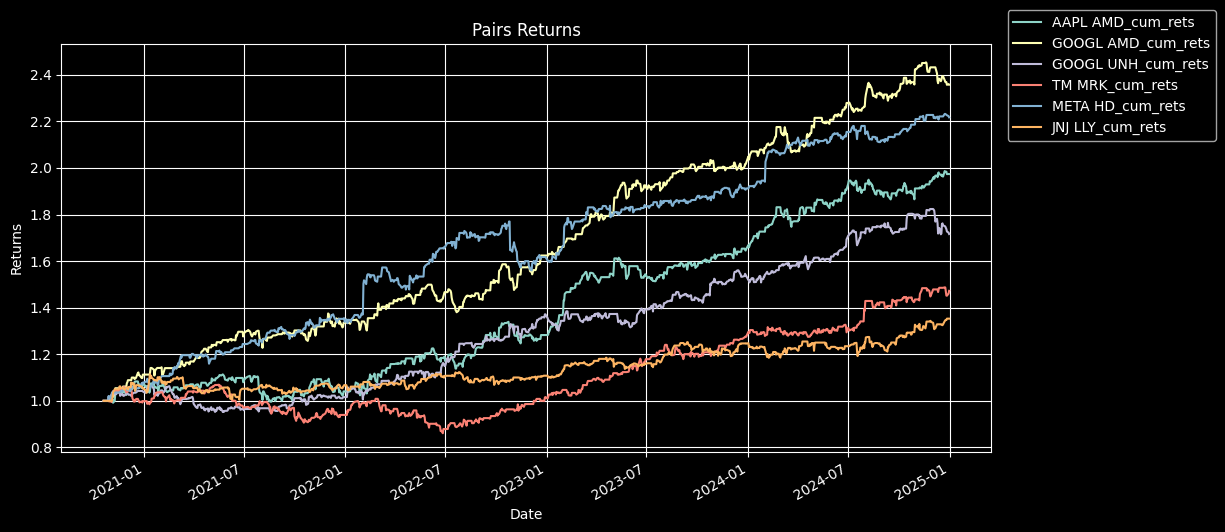

In [19]:
rets0.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.grid(True)
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

Save the results to a CSV file

In [20]:
filename = 'pairs_rets.csv'
rets0.to_csv(filename)

Combine the results into a single equity curve

In [21]:
# Concatenate the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

# Equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

# Sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# Square root of sample size for correct number of bins for returns distribution
sample_size = len(final_res)
bin_count = np.sqrt(sample_size)
print('Bin Count =', bin_count)

Bin Count = 32.49615361854384


Compute the returns for the pairs

In [22]:
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

Plot the distribution of returns

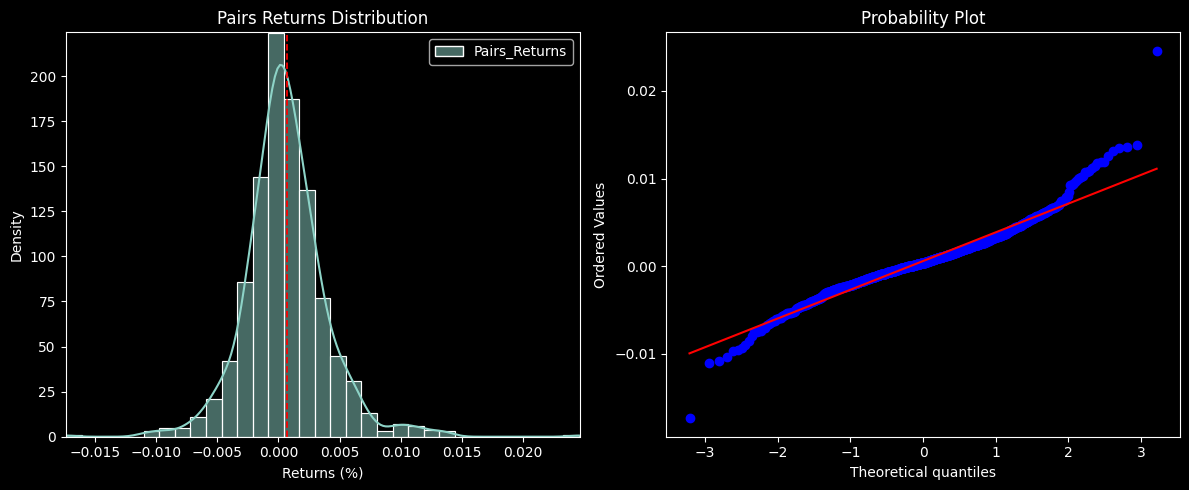

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.histplot(Pair_Rets, kde = True, bins=int(np.ceil(bin_count)), label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=0.000709, color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show()

Statistics for the returns

In [24]:
Pair_Rets.Pairs_Returns.describe()

count    1056.000000
mean        0.000588
std         0.003362
min        -0.017360
25%        -0.001199
50%         0.000382
75%         0.002264
max         0.024585
Name: Pairs_Returns, dtype: float64

In [25]:
perf = final_res.calc_stats()

In [26]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 6


In [27]:
# Set SPY as benchmark
bench = df_prices.loc[str(Pair_Rets.index[0]):str(Pair_Rets.index[-1])].SPY.pct_change().dropna()
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

## 6. Portfolio Performance

Start date,2020-10-21
End date,2024-12-31
Total months,50
,Backtest
Annual return,15.804%
Cumulative returns,84.836%
Annual volatility,5.34%
Sharpe ratio,2.78
Calmar ratio,4.03
Stability,0.98
Max drawdown,-3.918%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.92,2022-10-18,2022-11-15,2022-12-29,53
1,2.42,2021-12-01,2021-12-27,2022-01-18,35
2,2.31,2021-07-21,2021-08-04,2021-11-01,74
3,2.03,2024-08-07,2024-09-10,2024-10-09,46
4,1.92,2022-07-12,2022-07-21,2022-07-27,12


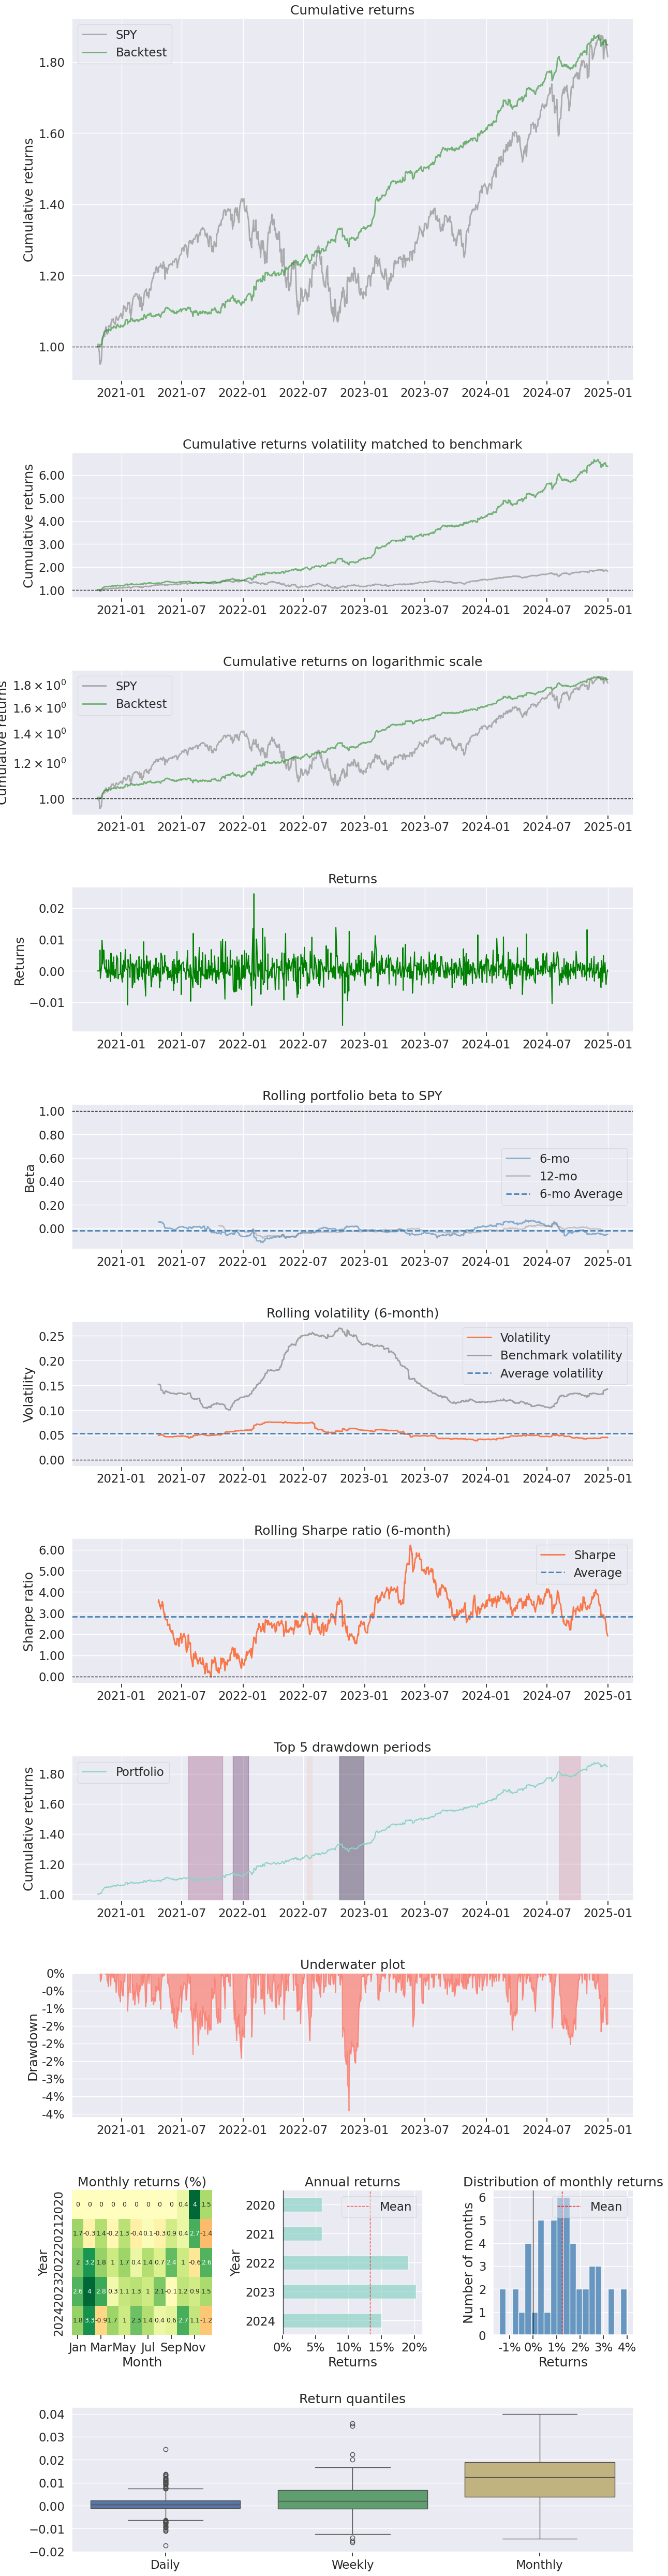

In [28]:
fig = pf.create_returns_tear_sheet(Pair_Rets.Pairs_Returns, benchmark_rets=bench)

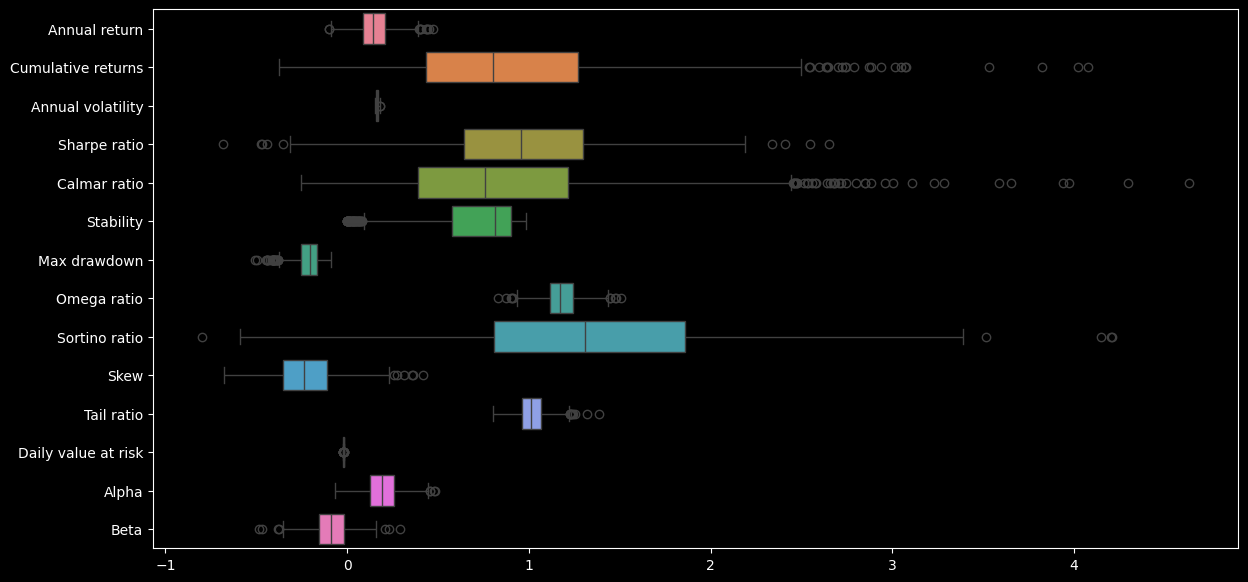

In [29]:
plt.figure(figsize=(14, 7))
pf.plot_perf_stats(factor_returns=Pair_Rets.Pairs_Returns, returns=bench)
plt.show()

In [30]:
# === TL;DR sanity checker for strategy vs SPY benchmark ====================

import numpy as np
import pandas as pd

# ── 1. Align the two return series to the same daily calendar ──────────────
bench = df_prices['SPY'].pct_change().loc[Pair_Rets.index.min():Pair_Rets.index.max()]
ret   = Pair_Rets['Pairs_Returns'].reindex(bench.index, fill_value=0)
bench = bench.fillna(0)                         # keep calendar intact

# ── 2. Basic stats (daily and annualised) ──────────────────────────────────
mu_d,  sd_d  = ret.mean(),  ret.std()
mu_b,  sd_b  = bench.mean(), bench.std()

raw_sharpe   = mu_d / sd_d
ann_sharpe   = raw_sharpe * np.sqrt(252)

print("Strategy daily μ  :", round(mu_d, 6))
print("Strategy daily σ  :", round(sd_d, 6))
print("Raw Sharpe        :", round(raw_sharpe, 3))
print("Annualised Sharpe :", round(ann_sharpe, 2))
print("Benchmark daily μ :", round(mu_b, 6))
print("Benchmark daily σ :", round(sd_b, 6))

# ── 3. Integrity checks ────────────────────────────────────────────────────
print("\nNaNs in strategy returns :", ret.isna().sum())
print("NaNs in benchmark returns :", bench.isna().sum())
print("Non-zero strategy days    :", (ret != 0).sum())
print("Calendar mismatch days    :", len(ret.index.symmetric_difference(bench.index)))

# ── 4. Quick drawdown + mean / std histo info (optional) ───────────────────
dd = (1+ret).cumprod().div((1+ret).cumprod().cummax()) - 1
print("Max drawdown              :", round(dd.min()*100, 2), "%")


Strategy daily μ  : 0.000588
Strategy daily σ  : 0.003362
Raw Sharpe        : 0.175
Annualised Sharpe : 2.77
Benchmark daily μ : 0.000622
Benchmark daily σ : 0.010357

NaNs in strategy returns : 0
NaNs in benchmark returns : 0
Non-zero strategy days    : 1044
Calendar mismatch days    : 0
Max drawdown              : -3.92 %
